In [91]:
import pandas as pd
import scipy
from scipy import stats
from scipy import linalg
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pingouin as pg
from scipy.stats import levene
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sa
import plotly.express as px
import pingouin as pg
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu


sns.set(rc={'figure.figsize':(12,6)}, style = 'whitegrid')

In [3]:
df = pd.read_csv('churn.csv')
df

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0          3.67                   5.0                   4.7       1.10   
1          8.26                   5.0                   5.0       1.00   
2          0.77                   5.0                   4.3       1.00   
3          2.36                   4.9                   4.6       1.14   
4          3.13                   4.9                   4.4       1.19   
...         ...                   ...                   ...        ...   
49995      5.63                   4.2                   5.0       1.00   
49996      0.00                   4.0                   NaN       1.00   
49997      3.86                   5.0                   5.0       1.00   
49998      4.58                   3.5                   3.0       1.00   
49999      3.49                   5.0                   NaN       1.00   

                 city last_trip_date    phone signup_date  surge_pct  \
0      King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1             Astapor     2014-05-05  Android  2014-01-29        0.0   
2             Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3      King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4          Winterfell     2014-03-15  Android  2014-01-27       11.8   
...               ...            ...      ...         ...        ...   
49995  King's Landing     2014-06-05   iPhone  2014-01-25        0.0   
49996         Astapor     2014-01-25   iPhone  2014-01-24        0.0   
49997      Winterfell     2014-05-22  Android  2014-01-31        0.0   
49998         Astapor     2014-01-15   iPhone  2014-01-14        0.0   
49999         Astapor     2014-04-20  Android  2014-01-18        0.0   

       trips_in_first_30_days  luxury_car_user  weekday_pct  
0                           4             True         46.2  
1                           0            False         50.0  
2                           3            False        100.0  
3                           9             True         80.0  
4                          14            False         82.4  
...                       ...              ...          ...  
49995                       0            False        100.0  
49996                       1            False          0.0  
49997                       0             True        100.0  
49998                       2            False        100.0  
49999                       0            False          0.0  

[50000 rows x 12 columns]

In [28]:
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)

In [29]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [30]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

In [31]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [35]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

days_since_last_trip      churn
0                        14  not_churn
1                        57      churn
2                       175      churn
3                         2  not_churn
4                       108      churn
...                     ...        ...
49995                    26  not_churn
49996                   157      churn
49997                    40      churn
49998                   167      churn
49999                    72      churn

[50000 rows x 2 columns]

In [36]:
df.churn.value_counts(normalize = True).mul(100)

churn
churn        62.392
not_churn    37.608
Name: proportion, dtype: float64

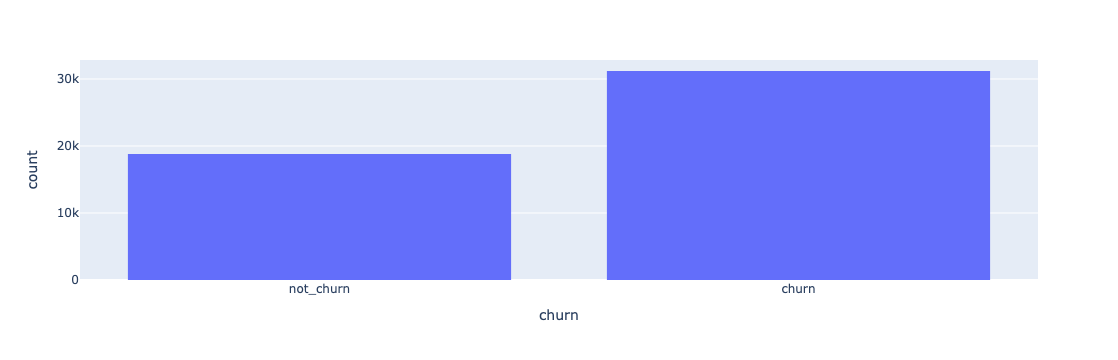

In [95]:
fig = px.histogram(df, x = 'churn')
fig.show()

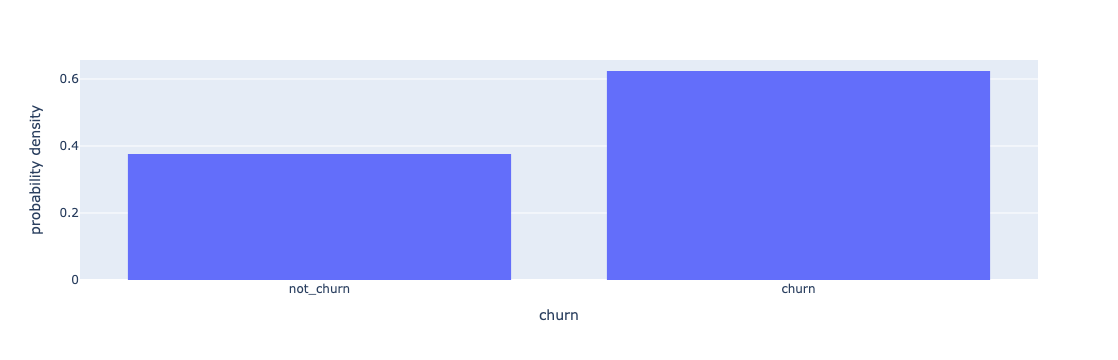

In [94]:
fig = px.histogram(df, x = 'churn', histnorm = 'probability density')
fig.show()

In [49]:
pd.crosstab(df.churn, df.phone)

phone      Android  iPhone
churn                     
churn        11876   19057
not_churn     3146   15525

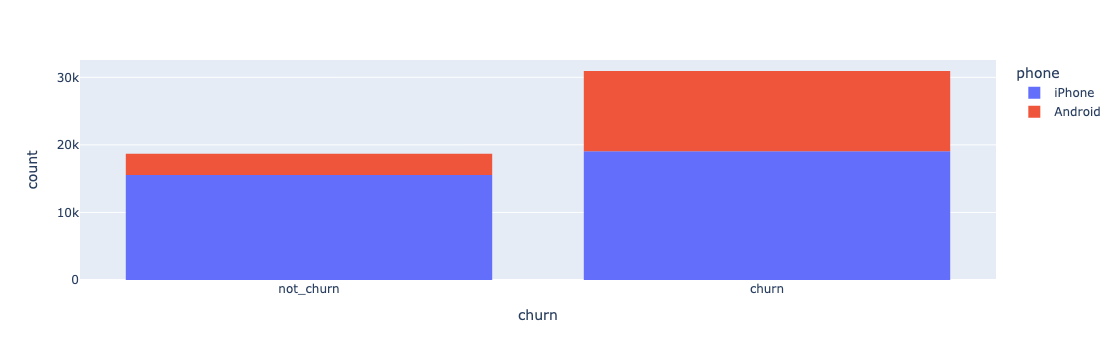

In [93]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x = 'churn', color = 'phone')
fig

In [53]:
from scipy.stats import chi2_contingency, chi2

In [54]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))

In [55]:
stat, p

(2558.394212267425, 0.0)

In [56]:
pd.crosstab(df.churn, df.city)

city       Astapor  King's Landing  Winterfell
churn                                         
churn        12306            3767       15123
not_churn     4228            6363        8213

In [59]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


In [60]:
prob = 0.95
alpa = 1 - prob
if p <= alpa:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


In [57]:
#
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))

In [58]:
stat, p

(3821.5510225559633, 0.0)

In [69]:
#

df_ast = df.query("city == 'Astapor'").trips_in_first_30_days
df_kin = df.query("city == 'King\\'s Landing'").trips_in_first_30_days
df_win = df.query("city == 'Winterfell'").trips_in_first_30_days

In [71]:
stat, p_value = levene(df_ast, df_kin, df_win)
stat, p_value

(98.09872813049195, 3.0174362755471005e-43)

In [73]:
pg_test = pg.normality(data=df, dv='trips_in_first_30_days', group='city', method='normaltest')
pg_test

W  pval  normal
city                                      
King's Landing  12011.013892   0.0   False
Astapor         18186.739338   0.0   False
Winterfell      21390.545655   0.0   False

In [75]:
grouped_data = df.groupby('city')['trips_in_first_30_days'].apply(list)
grouped_data 

city
Astapor           [0, 3, 1, 1, 1, 4, 1, 1, 4, 1, 2, 0, 3, 6, 6, ...
King's Landing    [4, 9, 0, 1, 0, 6, 0, 0, 2, 24, 1, 2, 0, 0, 7,...
Winterfell        [14, 2, 2, 2, 1, 1, 3, 1, 1, 1, 0, 1, 3, 0, 1,...
Name: trips_in_first_30_days, dtype: object

In [79]:
groups = [group for group in grouped_data]
stat, p_value = kruskal(*groups)

In [83]:
print(f"Statistics: {stat}, p-value: {p_value}")

Statistics: 221.32105325317454, p-value: 8.724567791938856e-49


In [84]:
if p_value < 0.05:
    dunn_results = sp.posthoc_dunn(df, val_col='trips_in_first_30_days', group_col='city', p_adjust='bonferroni')
    print(dunn_results)

                     Astapor  King's Landing    Winterfell
Astapor         1.000000e+00    3.940849e-09  2.448501e-49
King's Landing  3.940849e-09    1.000000e+00  1.266032e-09
Winterfell      2.448501e-49    1.266032e-09  1.000000e+00


In [88]:
df_churn = df.query("churn == 'churn'").trips_in_first_30_days
df_not_churn = df.query("churn == 'not_churn'").trips_in_first_30_days

In [90]:
pg_test_2 = pg.normality(data=df, dv='trips_in_first_30_days', group='churn', method='normaltest')
pg_test_2

W  pval  normal
churn                                
not_churn  16960.202341   0.0   False
churn      36325.245749   0.0   False

In [92]:
# Применяем критерия Манна-Уитни:
stat, p_value = mannwhitneyu(df_not_churn, df_churn, alternative='two-sided')

print(f"Statistics: {stat}, p-value: {p_value}")

Statistics: 351842132.0, p-value: 0.0
